<a href="https://colab.research.google.com/github/cc4351/teamtracking/blob/master/1015_Chen_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# table of content

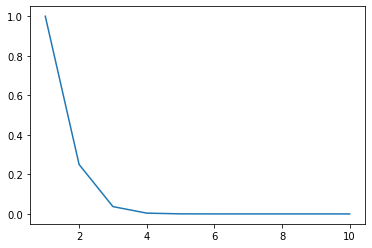

In [ ]:
x = range(1,11)
y = []
for i in x:
    y.append((1/i)**i)

plt.plot(x,y)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import statistics
import math
from time import time
import os
from collections import defaultdict
import pickle
import plotly.express as px
import queue
import pickle
import sys

In [ ]:
# replace the root path
# switching into the folder containing all the data and listdir
%cd '/content/drive/My Drive/Colab Notebooks/Molecule/data/RNN_train' 
!ls

/content/drive/My Drive/Colab Notebooks/Molecule/data/RNN_train
model.png		 receptorInfoLabeledPB.mat  sim4
receptorInfoAll.mat	 samplePBnnMatrix.pkl	    tracksFinal.mat
receptorInfoLabeled.mat  sim3


# Analysis of Simulated Data

In [ ]:
rootPath = r'sim4'
movieInfo = loadmat(os.path.join(rootPath, 'movieInfo.mat'))['movieInfo']
groundTruth = loadmat(os.path.join(rootPath, 'groundTruth.mat'))['receptorInfoLabeledPB']['receptorTraj'][0,0]
pixelSize = 80/1000
groundTruth /= pixelSize

In [ ]:
for x, y in catFrame[0]:
    min_dis = sys.maxsize
    min_a = -1
    min_b = -1
    for a, b in groundTruth[:,:,0]:
        dist = (x-a)**2 + (b-y)**2
        if dist < min_dis:
            min_dis = dist
            min_a = a
            min_b = b
    print(x, y, min_a, min_b, min_dis)

24.93147921324046 191.85297003825943 33.44269861331534 193.0826343098112 73.95292989694198
24.590128741572418 162.84540675538216 47.0946022601949 173.40578527198699 617.9729227643493
32.75759580515903 139.64357670342912 54.005939849244335 165.79456231174848 1135.366172902342
36.43289820899203 149.5078407821456 54.005939849244335 165.79456231174848 574.0690906728717
63.71208033033104 170.7441978779981 54.005939849244335 165.79456231174848 118.70805527727319
70.76443792813444 166.54439397182603 78.63548901482959 161.67963385571264 85.61933619669239
71.40378779048365 120.49997821731327 80.1658378762331 146.2886838302746 741.8308588971655
74.3554858723806 188.53143637151894 91.12455931461744 194.07206359322427 311.90037412103527
75.96725660116408 103.73887771616612 93.72178123865504 66.01668475101955 1738.1869872030263
90.89833881053511 136.51372106539114 80.1658378762331 146.2886838302746 210.7364733596518
92.51001348344919 135.68191862686058 80.1658378762331 146.2886838302746 264.8821395

In [ ]:
numFrames = len(movieInfo)
catFrame = [np.vstack((movieInfo['xCoord'][i][0][:,0], movieInfo['yCoord'][i][0][:,0])).T 
            if len(movieInfo['xCoord'][i][0])>0 else np.asarray([])for i in range(numFrames)]

# RNN pipeline

## data pre-processing

In [ ]:
rootPath = r'.'
tracks = loadmat(os.path.join(rootPath, 'receptorInfoLabeledPB'))['receptorInfoLabeledPB']
labeledTracks = tracks['receptorTraj'][0,0]
# movieInfo = np.transpose(labeledTracks, (2, 0, 1))


In [ ]:
labeledTracks.shape

(38, 2, 4001)

In [ ]:
# visualize the first track
track1 = labeledTracks[0]
df = pd.DataFrame(track1.transpose(), columns=['x', 'y'])
px.scatter_3d(df, x='x', y='y', z=df.index, size=np.ones(df.shape[0])*.5)

In [ ]:
# ref: https://stackoverflow.com/a/16193445
# get num_nn number of nearest neighbors for each particle
def nnMatrix(num_neighbors, particles):
    particleInfo = [np.asarray(frame) for frame in particles]
    loc_dic = defaultdict(dict)
    idx = 0
    for item in enumerate(particleInfo[:-1]):
        idx = item[0]
        frame = item[1]
        nextFrame = particleInfo[idx+1]
        for ptr in enumerate(frame):
            pt = ptr[1]
            if any(np.isnan(pt)) == True:
                continue
            dist = [np.sum((pt-p2)**2) for p2 in nextFrame]
            tmp_dic = {it[1]:it[0] for it in enumerate(dist)}
            # ret = heapq.nsmallest(num_neighbors, dist)
            dist = np.asarray(dist)
            i = np.argsort(dist)
            ret = i[np.isfinite(dist[i])][:num_neighbors]
            # numPadding = num_neighbors - len(ret)+1
            ret = np.append(ret, [-1])
            loc_dic[idx][ptr[0]] = {'x': pt[0], 'y': pt[1], 'nbrs': ret}
    # add x-y coordinate for last frame
    for ptr in enumerate(particleInfo[-1]):
        if np.isfinite(ptr[1][0]):
            loc_dic[idx+1][ptr[0]] = {'x':ptr[1][0], 'y':ptr[1][1], 'nbrs':[-1]}
    return list(loc_dic.values())

# get all possible hypotheses in padded format
def getHypTracks(nnMatrices, startFrame, startIdx, numNN, forwardProp = 3):
    numTrack = int((numNN**(forwardProp+1)-1)/(numNN-1))
    numFrames = len(nnMatrices)
    fakeDict = {'x':-1, 'y':-1, 'nbrs':[]}
    padding = [-1, -1]
    def helper(frame, idx, depth):
        if frame >= numFrames or depth > forwardProp or (idx > -1 and idx not in nnMatrices[frame]):
            return []
        if idx == -1:
            root = fakeDict
        else:
            root = nnMatrices[frame][idx]
        xy = [root['x'], root['y']]
        results = [xy+path for kid in root['nbrs'] if kid != None for path in helper(frame+1, kid, depth+1)] or [xy]
        return results
    results = []
    for track in helper(startFrame, startIdx, 0):
        endPadding = forwardProp + 1 - int(len(track)/2)
        tmp = padding + track + padding*(1+endPadding)
        tmp = np.asarray(tmp).reshape(-1, 2)
        results.append(tmp)
    if len(results) == 0:
        print(f"no {startIdx} in {startFrame}")
        return results
    fakeTrack = np.asarray([padding for i in range(forwardProp+3)])
    for _ in range(numTrack - len(results)):
        results.append(fakeTrack)
    return results
    
# get ground truth labels
def getTruth(trackSeg, nnSeg, idx, frame, numNN):
    # if the pt doesn't exist in current frame
    if np.isfinite(trackSeg[0][0]) == False:
        print(f"idx not exist in frame {frame}")
        return 
    # if the pt exist in current frame but not in the next frame
    elif len(trackSeg) == 1 or np.isfinite(trackSeg[0][1]) == False:
        print(f"idx not exist in frame {frame+1}")
        return ([0]*(numNN)+[1], [0, 1])
    # pt exist in both frames
    else:
        # double checking if this pt exist in this frame
        if idx not in nnSeg:
            print(f"idx {idx} not in frame {frame} --nnMatrices")
            return
        # the idx in next frame would be the same with this frame
        hot = idx
        # print("hot: ", hot)
        nbrs = nnSeg[idx]['nbrs']
        # print("nbrs: ", nbrs)
        # find the index of the matching particle in the nbrs list
        loc = np.where(nbrs ==hot)[0]
        if len(loc) == 0 or loc[0] == -1:
            print(f"current nbrs are {nbrs}: idx {idx} not found in nbrs")
            loc = -1
        else:
            loc = loc[0]
        encoding = [0]*(numNN+1)
        encoding[loc] = 1
        existence = [1, 0]
        return (encoding, existence)

In [ ]:
# nnMatrices = nnMatrix(3, movieInfo)
nnMatrices = pickle.load(open('./samplePBnnMatrix.pkl', 'rb'))

In [ ]:
d = 2
numNN = 3
batchNumTrack = int((numNN**(d+1)-1)/(numNN-1))
print("batchNumTrack: ", batchNumTrack)
allX = []
allAsgn = []
allExt = []
numTracks = len(labeledTracks)
numFrames = len(nnMatrices)-1
for idx in range(numTracks):
    for t in range(numFrames):
        if idx not in nnMatrices[t]:
            break
        tracks = getHypTracks(nnMatrices, t, idx, numNN, d)
        assert len(tracks) == batchNumTrack or len(tracks) == 0
        if len(tracks) == 0:
            print("oopsie")
            break
        allX.append(tracks)
        truth, existence = getTruth(labeledTracks[idx,:,t:t+2].T, nnMatrices[t], idx, t, numNN)
        assert len(truth) == numNN + 1
        assert sum(existence) == 1
        allAsgn.append(truth)
        allExt.append(existence)

batchNumTrack:  13
current nbrs are [16 15 22 -1]: idx 0 not found in nbrs
current nbrs are [27  3 12 -1]: idx 1 not found in nbrs
current nbrs are [20 10 15 -1]: idx 2 not found in nbrs
current nbrs are [21 25  7 -1]: idx 3 not found in nbrs
current nbrs are [36 25 30 -1]: idx 4 not found in nbrs
current nbrs are [11  7 -1]: idx 5 not found in nbrs
current nbrs are [ 7 19 21 -1]: idx 6 not found in nbrs
current nbrs are [32  9 33 -1]: idx 8 not found in nbrs
current nbrs are [21  6 19 -1]: idx 9 not found in nbrs
current nbrs are [25  0  3 -1]: idx 10 not found in nbrs
current nbrs are [ 7 -1]: idx 11 not found in nbrs
current nbrs are [ 7  3 21 -1]: idx 12 not found in nbrs
current nbrs are [28 15 29 -1]: idx 13 not found in nbrs
current nbrs are [ 9  6 21 -1]: idx 14 not found in nbrs
current nbrs are [ 5 21  3 -1]: idx 15 not found in nbrs
current nbrs are [21  3 15 -1]: idx 16 not found in nbrs
current nbrs are [ 8  9 33 -1]: idx 17 not found in nbrs
current nbrs are [10  0 29 -1]

In [ ]:
# unit test before training
# the index thingy need to be randomized/sorted in the u-track way

len(allX), len(allAsgn), len(allExt)

(50840, 50840, 50840)

In [ ]:
# numNN = 3
# d = 2
# t = 4000
# idx = 7
# # nnMatrices = nnMatrix(3, movieInfo)
# tracks = getHypTracks(nnMatrices, t, idx, numNN, d)
# # remember to check if t is the last frame
# truth, existence = getTruth(labeledTracks[idx,:,t:t+2].T, nnMatrices[t], idx, t, numNN)
# truth, existence
import random

c = list(zip(allX, allAsgn, allExt))
random.shuffle(c)
allX, allAsgn, allExt = zip(*c)
allX = list(allX)
allAsgn = list(allAsgn)
allExt = list(allExt)

allAsgn[0], allExt[0]

([1, 0, 0, 0], [1, 0])

In [ ]:
allX[0]

[array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 5.94978352, 12.4493243 ],
        [ 5.93745409, 12.49473248],
        [-1.        , -1.        ]]), array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 5.94978352, 12.4493243 ],
        [ 6.30155956, 15.9512826 ],
        [-1.        , -1.        ]]), array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 5.94978352, 12.4493243 ],
        [ 2.77884018,  9.43847762],
        [-1.        , -1.        ]]), array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 5.94978352, 12.4493243 ],
        [-1.        , -1.        ],
        [-1.        , -1.        ]]), array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 6.35341208, 15.98680597],
        [ 6.30155956, 15.9512826 ],
        [-1.        , -1.        ]]), array([[-1.        , -1.        ],
        [ 6.01981178, 12.47991293],
        [ 6.35341208, 1

## model

In [ ]:
# ref: https://keras.io/api/models/model_training_apis/
# model itself
class rnnModel(keras.Model):
    def __init__(self, numNN, t, d, numFilter = 12, k=64, numDim = 2, dropout = 0.25, t_init = 0, batch_size = None):
        super(rnnModel, self).__init__()
        dt = t + d + 1 - t_init 
        rate = dropout
        # (numNN+1)**d := total number of hypotheses to consider
        # dt := length of each track
        # numDim := length of each datapoint 
        inputDimOne = int((numNN**(d+1)-1)/(numNN-1))
        input_size = (inputDimOne, dt, numDim)
        ins = keras.Input(shape=input_size, batch_size=batch_size)
        x = layers.Conv1D(numFilter, 3 , activation='relu',input_shape=input_size[2:])(ins)
        x = tf.reshape(x, x.shape[1:])
        x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(k, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(k))(x)
        x = layers.Dense(k, activation='relu')(x)
        x = layers.GaussianDropout(rate)(x)
        x = layers.Dense(1, activation='relu')(x)
        x = layers.GaussianDropout(rate)(x)
        x = tf.reshape(x, [1, x.shape[0], x.shape[1]])
        x = layers.MaxPool1D(pool_size=(numNN+1)**(d-1), name="pool1", padding="same")(x)
        x = tf.reshape(x, [x.shape[0], x.shape[1]])
        z = layers.Dense(k, input_shape =(numNN+1,1), activation='relu')(x)
        z = layers.GaussianDropout(rate)(z)
        z = layers.Dense(k, activation='relu')(z)
        z = layers.GaussianDropout(rate)(z)
        z = layers.Dense(numNN+1, activation='relu')(z)
        f1_output = layers.Softmax(name="assignment")(z)

        y = layers.Dense(k, input_shape =(numNN+1,1), activation='relu')(x)
        y = layers.GaussianDropout(rate)(y)
        y = layers.Dense(k, activation='relu')(y)
        y = layers.GaussianDropout(rate)(y)
        y = layers.Dense(2, activation='relu')(y)
        f2_output = layers.Softmax(name="existence")(y)

        ensemble = keras.Model(inputs=ins, outputs=[f1_output, f2_output])

        opt = keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False,
            name="Adam",
        )

        losses = {
            "assignment": "categorical_crossentropy",
            "existence": "categorical_crossentropy",
        }

        lossWeights = {"assignment": 1.0, "existence": 1.0}
        # keras.utils.plot_model(ensemble, show_shapes=True)
        ensemble.compile(
            optimizer=opt,
            loss=losses,
            metrics=['accuracy'],
            loss_weights=lossWeights,
            weighted_metrics=None,
            run_eagerly=None,
        )

        self.model = ensemble
    def call(self, tracks, batch_size = 1, training=False):
        return self.model.predict(tf.constant(tracks), batch_size = batch_size)
        
    def train(self, tracks, labels, epochs = 10, batch_size = 1, callbacks=[], verbose = 1):
        defaultCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        return self.model.fit(tf.constant(tracks), labels,
                    epochs=epochs, batch_size=batch_size, callbacks=[defaultCallback],verbose=verbose)

In [ ]:
d = 2
numNN = 3
sampleModel = rnnModel(numNN = numNN, t = 2, d = d)

In [ ]:
# tfX = []
# for X in allX:
#     tfX.append(tf.constant(X))
dumX = tf.constant(allX)
asg = tf.constant(allAsgn)
ext = tf.constant(allExt)
dumX.shape, asg.shape, ext.shape

(TensorShape([50840, 13, 5, 2]),
 TensorShape([50840, 4]),
 TensorShape([50840, 2]))

In [ ]:
history = sampleModel.train(dumX, [asg, ext])

Epoch 1/10
50840/50840 [==============================] - 564s 11ms/step - loss: 0.0435 - assignment_loss: 0.0435 - existence_loss: 3.0893e-08 - assignment_accuracy: 0.9959 - existence_accuracy: 1.0000
Epoch 2/10
50840/50840 [==============================] - 543s 11ms/step - loss: 0.0353 - assignment_loss: 0.0353 - existence_loss: 2.8138e-11 - assignment_accuracy: 0.9959 - existence_accuracy: 1.0000
Epoch 3/10
50840/50840 [==============================] - 547s 11ms/step - loss: 0.0343 - assignment_loss: 0.0343 - existence_loss: 9.3792e-12 - assignment_accuracy: 0.9959 - existence_accuracy: 1.0000
Epoch 4/10
50840/50840 [==============================] - 577s 11ms/step - loss: 0.0333 - assignment_loss: 0.0333 - existence_loss: 3.2827e-11 - assignment_accuracy: 0.9959 - existence_accuracy: 1.0000
Epoch 5/10
50840/50840 [==============================] - 564s 11ms/step - loss: 0.0328 - assignment_loss: 0.0328 - existence_loss: 7.0344e-12 - assignment_accuracy: 0.9959 - existence_accurac

In [ ]:
# TO-DO
# 1. batch size
# 2. lr_finder
# 3. think about the track prcessing by 13 vs. by 1, 
#    and the negative effect of padding the input with [-1]*hypTrackLength (aka that's what I do rn)
# 4. track maintenance